# Line-level text detection with Surya

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/surya-line-level-text-detection/surya-line-level-text-detection.ipynb)

<div class="alert alert-block alert-danger"> <b>Important note:</b> This notebook requires python >= 3.9. Please make sure that your environment fulfill to this requirement  before running it </div>

In this tutorial we will perform line-level text detection using [Surya](https://github.com/VikParuchuri/surya) toolkit and OpenVINO.

![line-level text detection](https://github.com/VikParuchuri/surya/blob/master/static/images/excerpt.png?raw=true)

[**image source*](https://github.com/VikParuchuri/surya)


Model used for line-level text detection based on [Segformer](https://arxiv.org/pdf/2105.15203.pdf). It has the following features:
* It is specialized for document OCR. It will likely not work on photos or other images.
* It is for printed text, not handwriting.
* The model has trained itself to ignore advertisements.
* Languages with very different character sets may not work well.


#### Table of contents:

- [Fetch test image](#Fetch-test-image)
- [Run PyTorch inference](#Run-PyTorch-inference)
- [Convert model to OpenVINO Intermediate Representation (IR) format](#Convert-model-to-OpenVINO-Intermediate-Representation-(IR)-format)
- [Run OpenVINO model](#Run-OpenVINO-model)
- [Apply post-training quantization using NNCF](#Apply-post-training-quantization-using-NNCF)
    - [Prepare dataset](#Prepare-dataset)
    - [Quantize model](#Quantize-model)
- [Run quantized OpenVINO model](#Run-quantized-OpenVINO-model)
- [Interactive inference](#Interactive-inference)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/surya-line-level-text-detection/surya-line-level-text-detection.ipynb" />


## Fetch test image
[back to top ⬆️](#Table-of-contents:)

We will use an image from a randomly sampled subset of [DocLayNet](https://github.com/DS4SD/DocLayNet) dataset.

In [ ]:
import os

os.environ["GIT_CLONE_PROTECTION_ACTIVE"] = "false"

%pip install -q "openvino>=2024.2.0" "nncf>=2.11.0"
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "transformers<=4.36.2" "surya-ocr==0.4.0" torch datasets "gradio>=4.19" Pillow

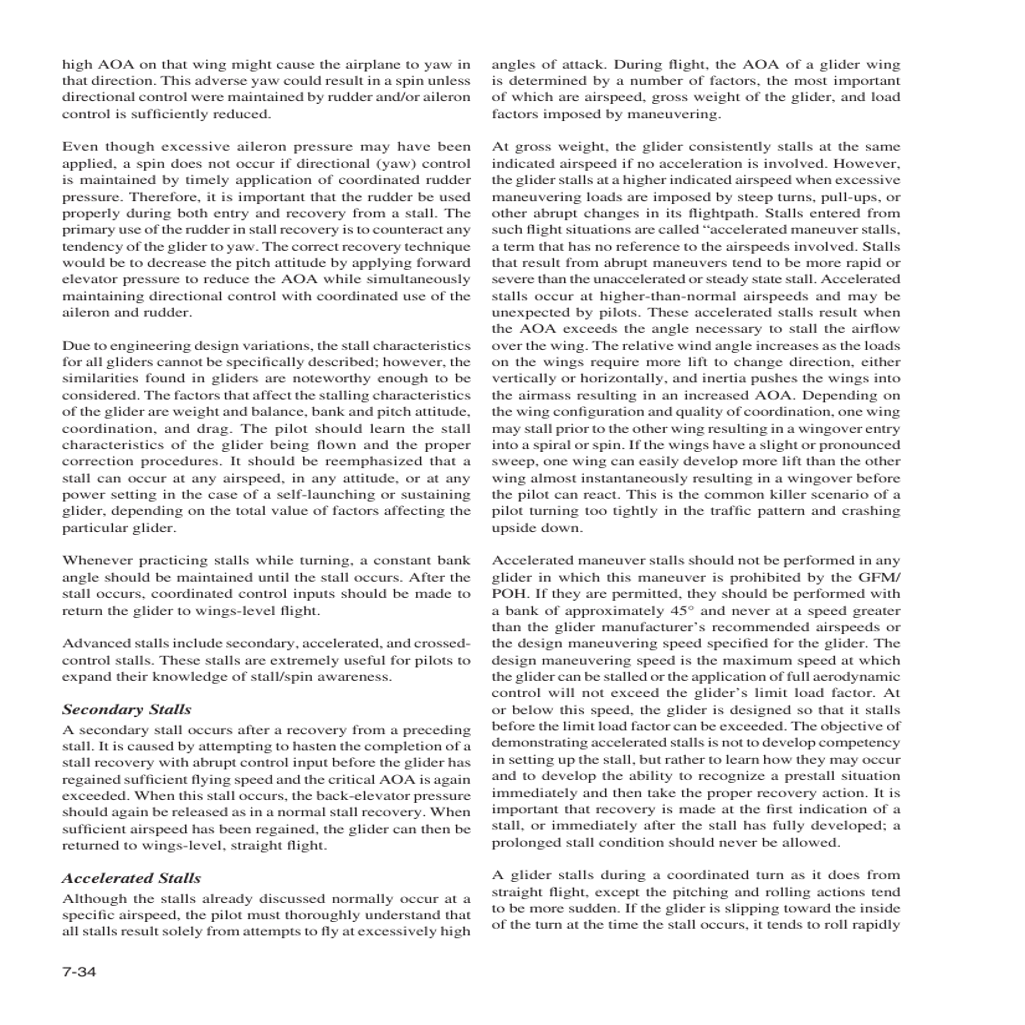

In [2]:
from datasets import load_dataset


def fetch_image():
    dataset = load_dataset("vikp/doclaynet_bench", split="train", streaming=True)
    return next(iter(dataset))["image"]


test_image = fetch_image()
test_image

## Run PyTorch inference
[back to top ⬆️](#Table-of-contents:)

To perform line-level text detection we will use `load_model` and `load_processor` functions from `surya` package. We will also use `batch_inference` function which performs pre and post processing.

In [3]:
# Predictions visualization function
from PIL import ImageDraw


def visualize_prediction(image, prediction):
    image = image.copy()
    draw = ImageDraw.Draw(image)

    for polygon_box in prediction.bboxes:
        draw.rectangle(polygon_box.bbox, width=1, outline="red")

    display(image)

/home/maleksandr/test_notebooks/check_nb/openvino_notebooks/notebooks/surya-line-level-text-detection/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading detection model vikp/surya_det2 on device cpu with dtype torch.float32


Detecting bboxes: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]


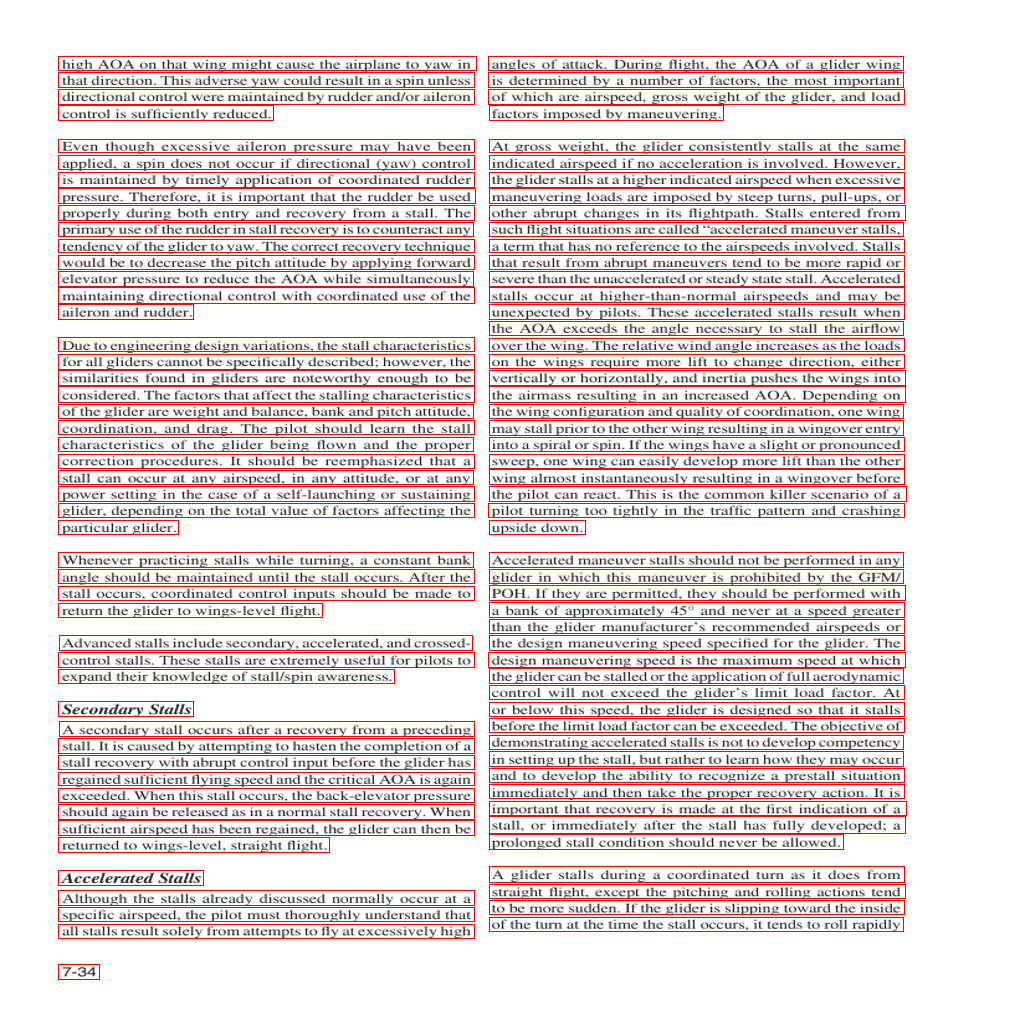

In [4]:
from surya.detection import batch_text_detection
from surya.model.detection.segformer import load_model, load_processor

model, processor = load_model(), load_processor()

predictions = batch_text_detection([test_image], model, processor)

visualize_prediction(test_image, predictions[0])

## Convert model to OpenVINO Intermediate Representation (IR) format
[back to top ⬆️](#Table-of-contents:)

For best results with OpenVINO, it is recommended to convert the model to OpenVINO IR format. OpenVINO supports PyTorch via Model conversion API.
To convert the PyTorch model to OpenVINO IR format we will use `ov.convert_model` of [model conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html). The `ov.convert_model` Python function returns an OpenVINO Model object ready to load on the device and start making predictions.

`ov.convert_model` requires a sample of original model input. We will use image pre-processing from `surya` package to prepare example input.

In [5]:
# Build example input
from surya.input.processing import prepare_image
import torch


def build_example_input(image, processor):
    input_values = prepare_image(image.convert("RGB"), processor)

    return {"pixel_values": torch.unsqueeze(input_values, 0)}


example_input = build_example_input(test_image, processor)

In [6]:
# Convert model
import openvino as ov
from pathlib import Path

ov_model = ov.convert_model(model, example_input=example_input)

FP_MODEL_PATH = Path("model.xml")
INT8_MODEL_PATH = Path("int8_model.xml")

ov.save_model(ov_model, FP_MODEL_PATH)

## Run OpenVINO model
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO

In [7]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

We want to reuse model results postprocessing implemented in `batch_inference` function. In order to do that we implement simple wrappers for OpenVINO model with interface required by `batch_inference` function.

Detecting bboxes: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


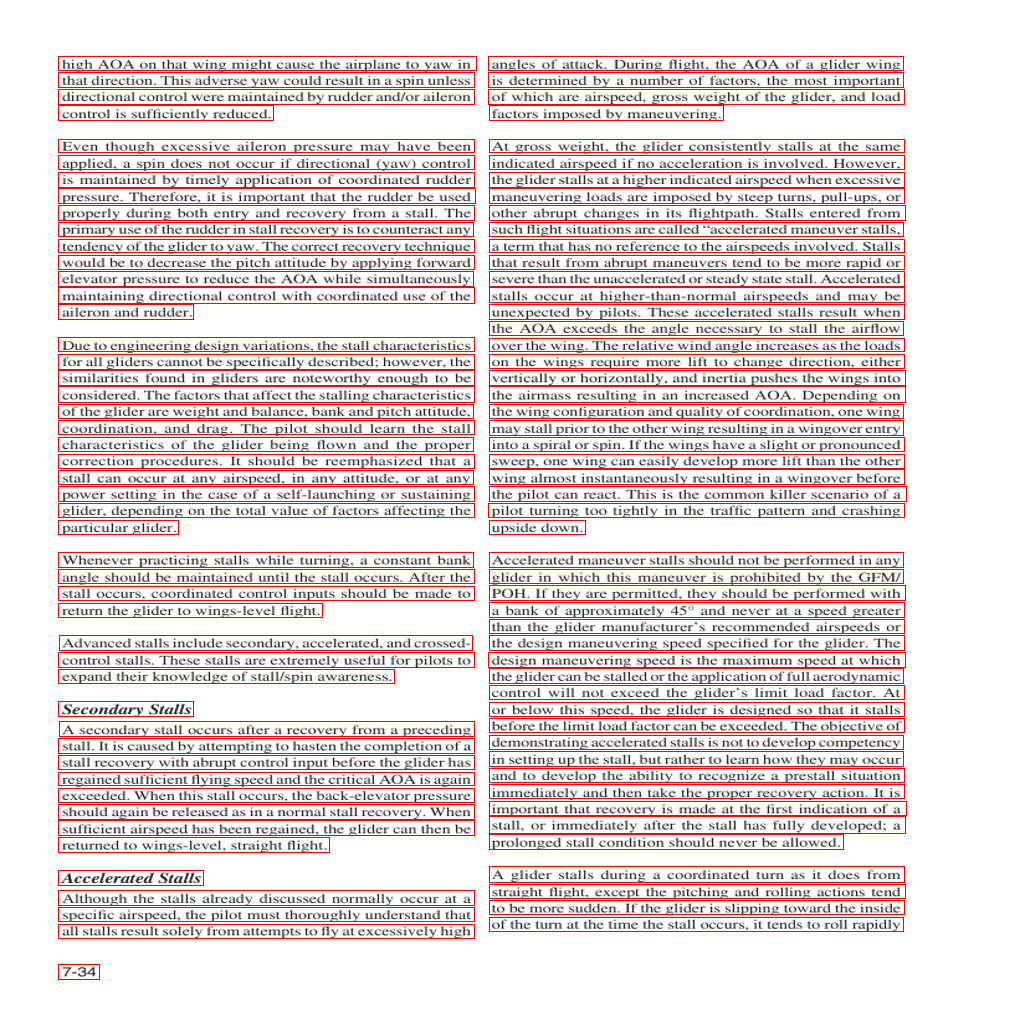

In [8]:
core = ov.Core()

# Compile OpenVINO model for loading on device
compiled_ov_model = core.compile_model(ov_model, device.value)


class OVModelWrapperResult:
    def __init__(self, logits):
        self.logits = logits


class OVModelWrapper:
    dtype = torch.float32
    device = model.device
    config = model.config

    def __init__(self, ov_model) -> None:
        self.ov_model = ov_model

    def __call__(self, **kwargs):
        # run inference on preprocessed data and get image-text similarity score
        logits = self.ov_model(kwargs)[0]
        return OVModelWrapperResult(torch.from_numpy(logits))


ov_model_wrapper = OVModelWrapper(compiled_ov_model)

ov_predictions = batch_text_detection([test_image], ov_model_wrapper, processor)

visualize_prediction(test_image, ov_predictions[0])

## Apply post-training quantization using NNCF
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding the quantization layers into the model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. The framework is designed so that modifications to your original training code are minor. Quantization is the simplest scenario and requires a few modifications.

The optimization process contains the following steps:

1. Create a dataset for quantization.
1. Run `nncf.quantize` for getting a quantized model.


Please select below whether you would like to run quantization to improve model inference speed.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take a long time.

In [9]:
to_quantize = widgets.Checkbox(
    value=True,
    description="Quantization",
    disabled=False,
)

to_quantize

Checkbox(value=True, description='Quantization')

In [10]:
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

Free resources before quantization.

In [ ]:
import gc

del model
del ov_model
del compiled_ov_model
del ov_model_wrapper

gc.collect();

### Prepare dataset
[back to top ⬆️](#Table-of-contents:)

We create calibration dataset with randomly sampled set of images from [DocLayNet](https://github.com/DS4SD/DocLayNet).

In [12]:
%%skip not $to_quantize.value

from surya.input.processing import split_image


def prepare_calibration_dataset(size=1, buffer_size=1):

    def collate_fn(data):
        image = data[0]["image"].convert("RGB")
        image_splits, _ = split_image(image, processor)
        image_splits = prepare_image(image_splits[0], processor)

        return image_splits

    dataset = load_dataset("vikp/doclaynet_bench", split="train", streaming=True)
    train_dataset = dataset.shuffle(seed=42, buffer_size=buffer_size)
    dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1)

    def prepare_calibration_data(dataloader, size):
        data = []
        counter = 0
        for batch in dataloader:
            if counter == size:
                break
            counter += 1
            batch = batch.to(torch.float32)
            batch = batch.to("cpu")
            data.append({"pixel_values": torch.stack([batch])})
        return data

    return prepare_calibration_data(dataloader, size)


calibration_dataset = prepare_calibration_dataset()

### Quantize model
[back to top ⬆️](#Table-of-contents:)

Create a quantized model from the `FP16` model.

In [13]:
%%skip not $to_quantize.value

import nncf

quantized_ov_model = nncf.quantize(
    model=core.read_model(FP_MODEL_PATH),
    calibration_dataset=nncf.Dataset(calibration_dataset),
    advanced_parameters=nncf.AdvancedQuantizationParameters(
        activations_quantization_params=nncf.quantization.advanced_parameters.QuantizationParameters(per_channel=False)
    ),
)

ov.save_model(quantized_ov_model, INT8_MODEL_PATH)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, openvino


Output()

Output()

## Run quantized OpenVINO model
[back to top ⬆️](#Table-of-contents:)

Now we ready to detect lines with `int8` OpenVINO model.

Detecting bboxes: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


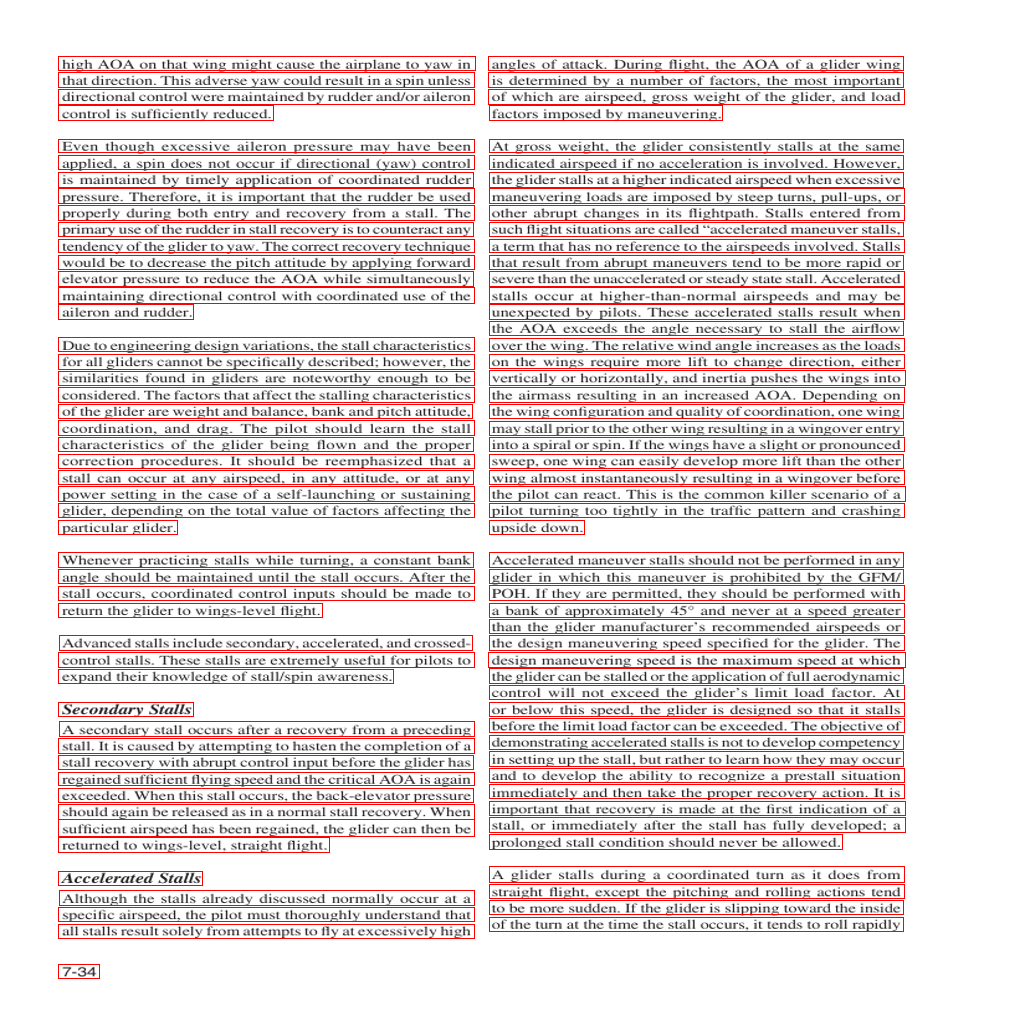

In [14]:
%%skip not $to_quantize.value

# Compile OpenVINO model for loading on device
compiled_int8_ov_model = core.compile_model(quantized_ov_model, device.value)

int8_ov_model_wrapper = OVModelWrapper(compiled_int8_ov_model)

int8_ov_predictions = batch_text_detection([test_image], int8_ov_model_wrapper, processor)

visualize_prediction(test_image, int8_ov_predictions[0])

## Interactive inference

[back to top ⬆️](#Table-of-contents:)

Now, it is your turn! Feel free to upload an image, using the file upload window.

Below you can select which model to run: original or quantized.

In [ ]:
from pathlib import Path

quantized_model_present = Path(INT8_MODEL_PATH).exists()

use_quantized_model = widgets.Checkbox(
    value=True if quantized_model_present else False,
    description="Use quantized model",
    disabled=not quantized_model_present,
)

use_quantized_model

In [ ]:
import gradio as gr

compiled_model = ov.compile_model(INT8_MODEL_PATH if use_quantized_model.value else FP_MODEL_PATH, device.value)


def predict(image):
    predictions = batch_text_detection([image], OVModelWrapper(compiled_model), processor)

    image = image.copy()
    draw = ImageDraw.Draw(image)

    for polygon_box in predictions[0].bboxes:
        draw.rectangle(polygon_box.bbox, width=1, outline="red")

    return image


demo = gr.Interface(
    predict,
    gr.Image(label="Image", type="pil", format="pil"),
    gr.Image(label="Result"),
    examples=[test_image],
)
try:
    demo.launch(debug=True, height=1000)
except Exception:
    demo.launch(share=True, debug=True, height=1000)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/